# Reversible Pattern Formation

> The following code depends on the reaction-diffusion-solver package: [https://github.com/Shiling42/reaction-diffusion-solver](https://github.com/Shiling42/reaction-diffusion-solver)

## Define reaction diffusion system

In [4]:
from rdsolver.reaction_diffu import *
import matplotlib as mpl

contrast  = lambda x: (np.max(x)-np.min(x))/(np.max(x)+np.min(x))

def plot_pattern(RPdis,ifplotv=False,ifinit=True):
    space_size = np.shape(RPdis[0])[0]
    space = np.linspace(0,1,space_size)
    if ifinit:
        plt.figure(figsize = (9,6))
    plt.plot(np.linspace(0,1,int(space_size/2)),RPdis[0,:int(space_size/2)],linewidth = 2,label='u')
    plt.fill_between(np.linspace(0,1,int(space_size/2)),RPdis[0,:int(space_size/2)], y2=0,alpha=0.1, interpolate=False,label=None)
    if ifplotv:
        plt.plot(np.linspace(0,1,int(space_size/2)),RPdis[1,:int(space_size/2)],linewidth = 2,label='v')
        plt.fill_between(np.linspace(0,1,int(space_size/2)),RPdis[1,:int(space_size/2)], y2=0,alpha=0.1, interpolate=False,label=None)
    plt.legend(fontsize = 24)

    plt.yticks(np.arange(0, 3, 1),fontsize=24)


    plt.xticks(np.arange(0, 1.1,1),fontsize=24)

    ax = plt.gca()

    # 设置左边框的线条粗细为3个像素
    ax.spines['left'].set_linewidth(1.5)

    # 设置底部边框的线条粗细为2个像素
    ax.spines['bottom'].set_linewidth(1.5)

    # 设置右边框和顶部边框不显示
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    plt.tick_params(axis='both', which='major', width=1.5)
    plt.xlabel(r"$x$",fontsize = 24)
    plt.ylabel("concentration",fontsize = 24)
    # plt.savefig("1Dpattern.svg",bbox_inches='tight')
    # plt.show()
    # plt.close()


In [5]:
def visibility(mat):
    matmin = np.min(mat)
    matmax = np.max(mat)
    return (matmax-matmin)/(matmax+matmin)

def plotpattern(pdis,save=True,cmap='viridis',rescaled = False):
    dis = np.array(pdis)
    vmax  = np.max(dis[0])+np.max(dis[1])
    vmax0 = vmax
    vmax1 = vmax
    vmax3 = vmax
    utot = np.array(dis[0]+dis[1])
    if rescaled:
        dis[0]=dis[0]/np.max(dis[0])
        dis[1]=dis[1]/np.max(dis[1])
        utot = utot/np.max(utot)
        vmax0 = 1
        vmax1 = 1
        vmax3 = 1
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(18,6))
    u0 = ax1.imshow(dis[0],cmap=cmap,vmin=0, vmax=vmax0)
    #ax1.axis('off')
    ax1.set_xticks([])
    ax1.tick_params(labelsize=15) 
    #ax1.set_yticks([])
    ax1.set_title(r"U-pattern         $\Omega_u=$%.2f"%visibility(dis[0]),fontsize=24,loc='right')
    clb = plt.colorbar(u0,ax=ax1, fraction=0.046, pad=0.04, orientation="horizontal")
    clb.ax.tick_params(labelsize=15) 
    u1 = ax2.imshow(dis[1],cmap=cmap,vmin=0, vmax=vmax1)
    ax2.set_title(r"V-pattern         $\Omega_v=$%.2f"%visibility(dis[1]),fontsize=24,loc='right')
    ax2.axis('off')
    clb = plt.colorbar(u1,ax=ax2, fraction=0.046, pad=0.04,orientation="horizontal")
    clb.ax.tick_params(labelsize=15) 
    utot = ax3.imshow(utot,cmap=cmap,vmin=0, vmax=vmax3)
    ax3.axis('off')
    ax3.set_title(r"UV-pattern   $\Omega_{u+v}=$%.2f"%visibility(dis[0]+dis[1]),fontsize=24,loc='right')
    clb = plt.colorbar(utot,ax=ax3,fraction=0.046, pad=0.04,orientation="horizontal")
    clb.ax.tick_params(labelsize=15) 
    return fig

class RevPattern(RDSystem):
    def __init__(self,
                 Du = 0.1, 
                 Dv = 4,
                 Keqmin = 0.1,
                 Keqmax = 4,
                 n=3,#catalytic order
                 k0 = 10,
                 space_size = 100,dim = 2,
                 dt=0.01,
                 boundary = 'periodic',
                 init_dis= 'random',
                 *args):
        self.Keqmin = Keqmin
        self.Keqmax = Keqmax
        self.n = n
        self.k0 = k0
        self.Du = Du,
        self.Dv = Dv,
        Reactant1 = Reactant(Du)
        Reactant2 = Reactant(Dv)
        reactants = [Reactant1,Reactant2]
        RDSystem.__init__(self,reactants,
                          space_size =space_size, 
                          init_dis = init_dis ,
                          boundary = boundary, dim=dim,dt=dt)
        self.dx = 1
        a = np.random.rand(*np.shape(self.dis[0]))
        a = np.linspace(0,2*np.pi,*np.shape(self.dis[0]))
        self.dis[0,:] = (-np.cos(a)+1)*2.2
        
        self.dis[1] = self.dis[1]
        
    def reaction(self):
        u = self.dis
        dudt_reac = np.zeros(np.shape(self.dis))
        drdt = self.k0* (u[1] - self.Keqmax *u[0]**2) + np.power(u[0],self.n)*(u[1] - self.Keqmin *u[0]**2) 
        if self.dim==2: #2D 
            dudt_reac[0,:,:] += 2*drdt
            dudt_reac[1,:,:] += -drdt
        elif self.dim == 1:
            dudt_reac[0,:] += 2*drdt
            dudt_reac[1,:] += -drdt
        return dudt_reac*0.05

In [126]:
%%time
space_size = 300
Kmin_list = np.logspace(-3,np.log(0.2)/np.log(10),num=8,base=10)#[0.01,0.03,0.07,0.1,0.13,0.17,0.2,0.25,0.3,0.4,0.5,0.6];
#Du_list = np.logspace(-1,np.log(2)/np.log(10),num=3,base=10)
Du_list = np.linspace(0.1, 3, 5)
#Du_list = 1/np.linspace(1/3, 10, 5)
RPD_list = []
RP_list = []
for Du in Du_list:
    RP_list = []
    for Kmin in Kmin_list:
        RPd = RevPattern(Du = Du, 
                    Dv = 10,
                    Keqmin = Kmin,
                    Keqmax = 3,
                    space_size = space_size,
                    k0 =0.3,
                    dim=1,
                    n=4,boundary = 'Neumann')
        RPd.dt=0.03
        if Kmin< 0.05:
            RPd.evolve(10000)
        else:
            RPd.evolve(5000)    
        RP_list.append(np.copy(RPd.dis))
    RPD_list.append(RP_list)
        #plt.plot(RP.dis[0,:])
        #plt.plot(RP.dis[1,:])
        #plt.ylim([0,6])
        #plt.show()
        #plt.close()

CPU times: user 5min 25s, sys: 1.09 s, total: 5min 27s
Wall time: 5min 27s


In [130]:
contra_list = [[contrast(RP[0,:]) for RP in RP_list] for RP_list in RPD_list]
print(contra_list)
Fc_list = [np.log(3/Kmin) for Kmin in Kmin_list]

[[0.9309351969368658, 0.9231459564686546, 0.9019880675804508, 0.8673124648994673, 0.8124055279560364, 0.73227545879446, 0.614985556151778, 0.4133867989209756], [0.8748525397881408, 0.8660090679103216, 0.8493485260696109, 0.8204004022222804, 0.7734039995559338, 0.7005254811225565, 0.5876506074597588, 0.3846130105412747], [0.8236929267770475, 0.8168677624881108, 0.8037933127355233, 0.7794592956054595, 0.73805557671998, 0.6701132285232211, 0.5607768078090702, 0.3542558630373065], [0.7785337561104269, 0.7728817607100898, 0.7614703471039935, 0.7404165328548554, 0.7011039207938072, 0.6388107164330283, 0.5333934693008452, 0.3219525360296939], [0.7317838986128915, 0.7248397984495529, 0.7140702294779838, 0.688817013465308, 0.644163854248969, 0.5943007115794967, 0.5006071814806297, 0.28666316121779245]]


## Thermodynamic bounds for Pattern formation

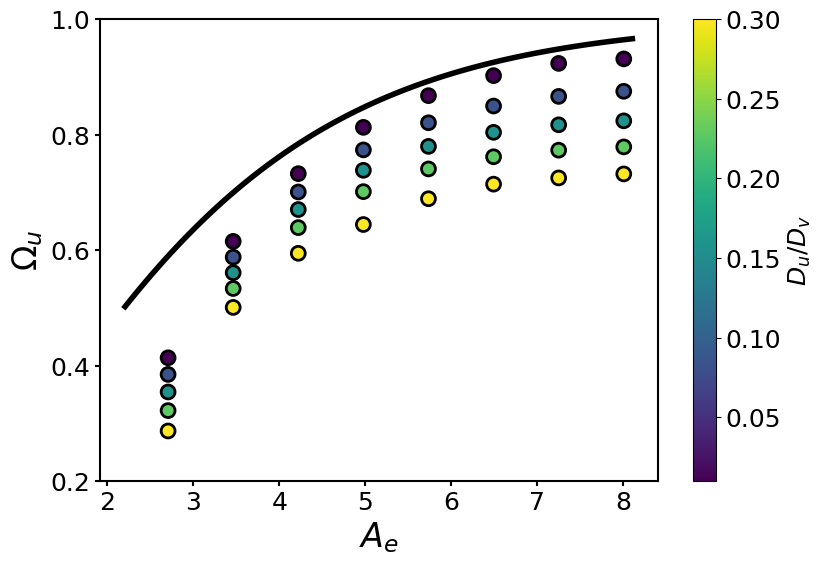

In [249]:
plt.figure(figsize = (9,6))
plt.style.use('default')
for i, contrast_ in enumerate(contra_list[:]):
    plt.scatter(Fc_list, contrast_, s=100, c= [Du_list[i]/10]*len(Fc_list), cmap='viridis', vmin=min(Du_list/10), vmax=max(Du_list/10),
               edgecolors='black', linewidth=2, marker='o')

cbar = plt.colorbar(label=r'$D_u/D_v$')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label=r'$D_u/D_v$', size=18)


#plt.plot(Fc_list,max_vb_list,linewidth=3.0)
x  = np.linspace(np.min(Fc_list)-0.5,np.max(Fc_list)+0.1,100)
y = np.tanh(x/4)
plt.plot(x,y,linewidth=4.0,color='black')
plt.xlabel(r"$A_e$",fontsize = 24)
plt.ylabel(r"$\Omega_u$",fontsize = 24)
plt.yticks(np.arange(0.2, 1.1, 0.2),fontsize=18)
# plt.legend(["Pattern contrast","Upper bound"],fontsize = 18)
plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
ax = plt.gca()

# 设置左边框的线条粗细为3个像素
ax.spines['left'].set_linewidth(1.5)

# 设置底部边框的线条粗细为2个像素
ax.spines['bottom'].set_linewidth(1.5)

# 设置右边框和顶部边框不显示
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=1.5)
plt.savefig("EC_visibility.svg",bbox_inches='tight')
plt.show()

In [255]:
def plot_pattern(RPdis,ifplotv=False,ifinit=True):
    space_size = np.shape(RPdis[0])[0]
    space = np.linspace(0,1,space_size)
    if ifinit:
        plt.figure(figsize = (9,3))
    plt.plot(np.linspace(0,1,int(space_size)),RPdis[0,:int(space_size)],linewidth = 2,label='u')
    plt.fill_between(np.linspace(0,1,int(space_size)),RPdis[0,:int(space_size)], y2=0,alpha=.1, interpolate=False,label=None)
    if ifplotv:
        plt.plot(np.linspace(0,1,int(space_size)),RPdis[1,:int(space_size)],linewidth = 2,label='v')
        plt.fill_between(np.linspace(0,1,int(space_size)),RPdis[1,:int(space_size)], y2=0,alpha=0.1, interpolate=False,label=None)
    #plt.legend(fontsize = 24)

    plt.yticks(np.arange(0, 4, 1),fontsize=20)


    plt.xticks(np.arange(0, 1.1,1),fontsize=20)

    ax = plt.gca()

    # 设置左边框的线条粗细为3个像素
    ax.spines['left'].set_linewidth(1.5)

    # 设置底部边框的线条粗细为2个像素
    ax.spines['bottom'].set_linewidth(1.5)

    # 设置右边框和顶部边框不显示
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    plt.tick_params(axis='both', which='major', width=1.5)
    plt.xlabel(r"$x$",fontsize = 20)
    plt.ylabel("u",fontsize = 20)
    # plt.savefig("1Dpattern.svg",bbox_inches='tight')
    # plt.show()
    # plt.close()

## Patterns under different diffusion constants

/var/folders/dn/dtd7094n2011y7c2pk4ch4gm0000gp/T/ipykernel_7075/473191275.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend([r'$D_u/D_v=0.01$','_nolegend_',r'$D_u/D_v=0.15$','_nolegend_',r'$D_u/D_v=0.3$'], fontsize=16,  loc='upper right')


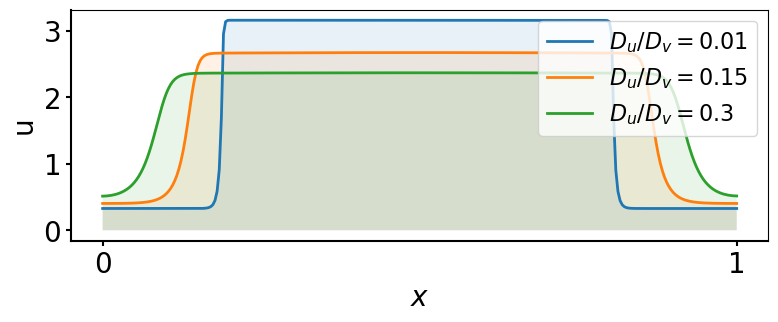

In [256]:
num=7
plt.figure(figsize = (9,3))
plot_pattern(RPD_list[0][4],ifinit=False,ifplotv=False)
plot_pattern(RPD_list[2][4],ifinit=False,ifplotv=False)
plot_pattern(RPD_list[4][4],ifinit=False,ifplotv=False)
plt.legend([r'$D_u/D_v=0.01$','_nolegend_',r'$D_u/D_v=0.15$','_nolegend_',r'$D_u/D_v=0.3$'], fontsize=16,  loc='upper right')
plt.savefig("1Dpattern_D.svg",bbox_inches='tight')  
#plt.legend(fontsize = 24)

## Pattern under differnet driving forces

/var/folders/dn/dtd7094n2011y7c2pk4ch4gm0000gp/T/ipykernel_7075/2630844019.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend([r'$A_e=6.5$','_nolegend_',r'$A_e=5.0$','_nolegend_',r'$A_e=3.5$'], fontsize=16, loc='upper right')


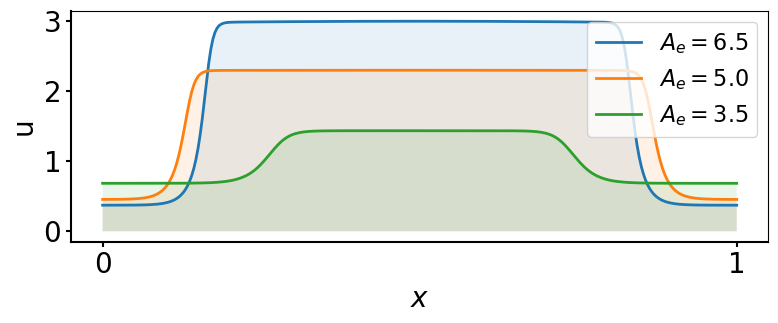

In [257]:
num=7
plt.figure(figsize = (9,3))
plot_pattern(RPD_list[2][3],ifinit=False,ifplotv=False)
plot_pattern(RPD_list[2][5],ifinit=False,ifplotv=False)
plot_pattern(RPD_list[2][7],ifinit=False,ifplotv=False) 
plt.legend([r'$A_e=6.5$','_nolegend_',r'$A_e=5.0$','_nolegend_',r'$A_e=3.5$'], fontsize=16, loc='upper right')
plt.savefig("1Dpattern_A.svg",bbox_inches='tight')  